# Data Generotor

- Task1: Select a portion of the large dataset with appropriate road ratio


- Task2: Transform data
    - Rotation etc
    - Split data into pieces

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import cv2

In [16]:
root_path = 'D://Data/massachusetts-roads-dataset/'
# root_path = '/home/renyan/ossdata/massachusetts-roads-dataset/'

road_class_type_path_from = 'tiff/'
road_class_type_path_to = 'tiff_select/'
road_class_type_path_to_split = "tiff_select_parts/"
road_path_from = root_path + road_class_type_path_from
road_path_to = root_path + road_class_type_path_to
road_path_to_split = root_path + road_class_type_path_to_split

## Selection

In [17]:
# read all original train set
def get_file_subpaths(path, whole = True, sort = True):
    path_prefix = path if whole else ""
    subpaths = [path_prefix + file_name for file_name in list(os.walk(path))[0][2]]
    if sort:
        subpaths.sort()
    return subpaths

In [18]:
# For labels: Select pairs with high road ratio as EXCELLENT DATASET
def road_ratio(label):
    flat = label.flatten()
    flat = flat/255 if flat.max() > 1 else flat
    return flat.sum()/np.prod(label.shape)

# For images: Select pairs with little white ratio as GOOD DATASET
def valid_ratio(img):
    flat = img.flatten()/255 if img.max() > 1 else img.flatten()
    valid_ratio = np.sum(np.ceil(1-flat))/np.prod(img.shape)
    return valid_ratio

In [19]:
# plot selected image-label pair with valid_ratio and road_ratio
def plot_selection(idx, p_img, p_lbl, valid_ratios, road_ratios, limit = 0):
    if limit == 0:
        limit = len(idx)
    for i in idx[:limit]:
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(cv2.imread(p_img[i]))
        plt.title(str(valid_ratios[i]))
        plt.subplot(1,2,2)
        plt.imshow(cv2.imread(p_lbl[i]))
        plt.title(str(road_ratios[i]))

In [20]:
# save files of old paths to new paths
# dilated_para: None for no dilation, [kernel, itr_num]
def save_selection(old_paths, new_paths, dilated_para = None):
    for i, (old_path, new_path) in enumerate(zip(old_paths, new_paths)):
        if dilated_para:
            kernel = np.ones((dilated_para[0], dilated_para[0]),np.uint8)
            t = cv2.dilate(cv2.imread(old_path), kernel, dilated_para[1])
        else:
            t = cv2.imread(old_path)
        cv2.imwrite(new_path, t)
    print("Done!")

In [32]:
# make directory
def mkdir_level2(folder_path, sub_folder_names = None):
    if not os.path.isdir(folder_path):
        os.mkdir(folder_path) 
        print(folder_path + " --- built!")
    if sub_folder_names:
        for sub_folder_name in sub_folder_names:
            if not os.path.isdir(folder_path + sub_folder_name + "/"):
                os.mkdir(folder_path + sub_folder_name + "/") 
        print("{} sub_folder done.".format(len(sub_folder_names)))

In [23]:
train_p_img = get_file_subpaths(road_path_from + "train/")
train_p_lbl = get_file_subpaths(road_path_from + "train_labels/")

In [24]:
valid_ratios = [valid_ratio(cv2.imread(t)) for t in tqdm(train_p_img)]

100%|██████████| 1108/1108 [02:52<00:00,  6.43it/s]


In [25]:
road_ratios = [road_ratio(cv2.imread(t)) for t in tqdm(train_p_lbl)]

100%|██████████| 1108/1108 [01:15<00:00, 14.62it/s]


In [26]:
valid_threshold = np.percentile(valid_ratios, 95)
road_threshold = np.percentile(road_ratios, 90)
print(valid_threshold, road_threshold)

0.9999985185185185 0.09712382222222224


In [27]:
valid_idx = np.where(valid_ratios >= np.float64(0.99))[0].tolist()
road_idx = np.where(road_ratios >= road_threshold)[0].tolist()
print(len(valid_idx), len(road_idx))

717 111


In [28]:
target_idx = list(set(valid_idx).intersection(set(road_idx)))
print("excel and valid ({}):\n {}".format(len(target_idx), target_idx))

excel and valid (92):
 [585, 598, 88, 601, 602, 89, 90, 618, 620, 637, 638, 639, 640, 127, 656, 661, 662, 663, 667, 676, 678, 682, 683, 684, 687, 699, 703, 704, 705, 706, 717, 719, 720, 721, 722, 723, 740, 741, 742, 743, 744, 751, 763, 764, 765, 766, 767, 768, 769, 773, 774, 278, 279, 793, 794, 795, 796, 797, 798, 799, 800, 290, 291, 292, 802, 803, 804, 306, 307, 308, 309, 824, 828, 829, 832, 833, 834, 326, 328, 341, 857, 858, 859, 860, 861, 862, 881, 882, 959, 985, 994, 995]


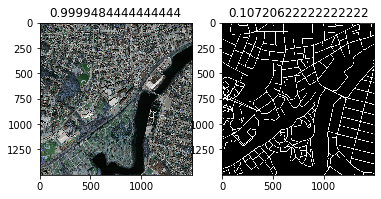

In [29]:
plot_selection(target_idx, train_p_img, train_p_lbl, valid_ratios, road_ratios, 1)

In [30]:
road_path_to

'D://Data/massachusetts-roads-dataset/tiff_select/'

In [33]:
mkdir_level2(road_path_to, ["train", "train_labels", "val", "val_labels", "test", "test_labels"])

D://Data/massachusetts-roads-dataset/tiff_select/ --- built!
6 sub_folder done.


In [45]:
# train image
old_paths = [train_p_img[i] for i in target_idx]
new_paths = [road_path_to + "train/" + file_name for file_name in [t.split("/")[-1] for t in old_paths]]
save_selection(old_paths, new_paths)

Done!


In [47]:
# tain label
old_paths = [train_p_lbl[i] for i in target_idx]
new_paths = [road_path_to + "train_labels/" + file_name for file_name in [t.split("/")[-1] for t in old_paths]]
save_selection(old_paths, new_paths, [5, 1])

Done!


In [50]:
# val image
old_paths = get_file_subpaths(road_path_from + "val/")
new_paths = [road_path_to + "val/" + file_name for file_name in get_file_subpaths(road_path_from + "val/", whole = False)]
save_selection(old_paths, new_paths)
# val label
old_paths = get_file_subpaths(road_path_from + "/val_labels/")
new_paths = [road_path_to + "val_labels/" + file_name for file_name in get_file_subpaths(road_path_from + "val_labels/", whole = False)]
save_selection(old_paths, new_paths)

Done!
Done!


In [51]:
# test image
old_paths = get_file_subpaths(road_path_from + "test/")
new_paths = [road_path_to + "test/" + file_name for file_name in get_file_subpaths(road_path_from + "test/", whole = False)]
save_selection(old_paths, new_paths)
# # test label
old_paths =  get_file_subpaths(road_path_from + "test_labels/")
new_paths = [road_path_to + "test_labels/" + file_name for file_name in  get_file_subpaths(road_path_from + "test_labels/", whole = False)]
save_selection(old_paths, new_paths)

Done!
Done!


## Split

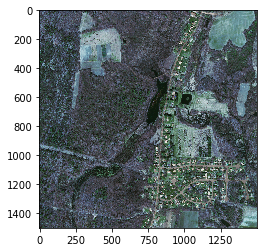

In [52]:
img = cv2.imread(train_p_img[1])
plt.imshow(img);

In [53]:
lt = img[0:int(img.shape[0]/2),0:int(img.shape[1]/2),:]
lb = img[int(img.shape[0]/2):,0:int(img.shape[1]/2),:]
rt = img[0:int(img.shape[0]/2),int(img.shape[1]/2):,:]
rb = img[int(img.shape[0]/2):,int(img.shape[1]/2):,:]

In [54]:
# get left-top, left-bottom, right-top, right-bottom parts saved
def save_split(old_paths, new_paths):
    for i, (old_path, new_path) in enumerate(zip(old_paths, new_paths)):
        new_root, suffix = new_path.split(".")
        img = cv2.imread(old_path)
        cv2.imwrite(new_root + "_p1." + suffix, img[0:int(img.shape[0]/2),0:int(img.shape[1]/2),:])
        cv2.imwrite(new_root + "_p2." + suffix, img[int(img.shape[0]/2):,0:int(img.shape[1]/2),:])
        cv2.imwrite(new_root + "_p3." + suffix, img[0:int(img.shape[0]/2),int(img.shape[1]/2):,:])
        cv2.imwrite(new_root + "_p4." + suffix, img[int(img.shape[0]/2):,int(img.shape[1]/2):,:])
    print("Done!")

In [55]:
mkdir_level2(road_path_to_split, ["train", "train_labels", "val", "val_labels", "test", "test_labels"])

D://Data/massachusetts-roads-dataset/tiff_select_parts/ --- built!
6 sub_folder done.


In [56]:
# train image
old_paths = get_file_subpaths(road_path_to + "train/")
new_paths = [road_path_to_split + "train/" + file_name for file_name in get_file_subpaths(road_path_to + "train/", whole = False)]
save_split(old_paths, new_paths)

Done!


In [57]:
# train labels
old_paths = get_file_subpaths(road_path_to + "train_labels/")
new_paths = [road_path_to_split + "train_labels/" + file_name for file_name in get_file_subpaths(road_path_to + "train_labels/", whole = False)]
save_split(old_paths, new_paths)

Done!


In [59]:
# val image
old_paths = get_file_subpaths(road_path_to + "val/")
new_paths = [road_path_to_split + "val/" + file_name for file_name in get_file_subpaths(road_path_to + "val/", whole = False)]
save_split(old_paths, new_paths)
# val label
old_paths = get_file_subpaths(road_path_to + "val_labels/")
new_paths = [road_path_to_split + "val_labels/" + file_name for file_name in get_file_subpaths(road_path_to + "val_labels/", whole = False)]
save_split(old_paths, new_paths)

Done!
Done!


In [60]:
# test image
old_paths = get_file_subpaths(road_path_to + "test/")
new_paths = [road_path_to_split + "test/" + file_name for file_name in get_file_subpaths(road_path_to + "test/", whole = False)]
save_split(old_paths, new_paths)
# test label
old_paths = get_file_subpaths(road_path_to + "test_labels/")
new_paths = [road_path_to_split + "test_labels/" + file_name for file_name in get_file_subpaths(road_path_to + "test_labels/", whole = False)]
save_split(old_paths, new_paths)

Done!
Done!
